# Black Jack stylised environment

## Deck Setup 
1. Card Suits : Spades, Hearts, Diamonds and Clubs
2. Face Cards : Kings, Queens and Jacks
3. Ace = Aces
4. Number cards : 2 to 10

# Card value setup

1. Face cards : 10
2. Ace : 11 if bust 1
3. Number : Numerical value equal to their number

# Reward Function

![Cost function](images/cost_function.png)

## Doubts
1. When calculating the score for the hand, when there is unusable ace, should be count that as 1 or 11?

In [7]:
import numpy as np
import random

from utils.blackjack_env_builder import BlackJackStylised
from utils.scorer import Scorer, quadratic_scorer
from tqdm import tqdm
from matplotlib import pyplot as plt
from general import plot_Q_values

In [29]:
class MonteCarloES:
    '''
    Monte Carlo Exploring starts algorithm
    '''
    
    # TODO Print the number of states and actions along with the defined init_configurations
    def __init__(self, states, actions, init_config:dict, verbose=False): # reward_function
        
        self.states = states
        self.actions = actions
        self.init_config = init_config
        # self.reward_function = reward_function
        self.initialize_Q_returns()
        
    def epsilon_greedy_policy(self, state):
        
        if random.random() < self.init_config['epsilon']:
            return random.choice(self.actions)
        else:
            return self._exploit(state)
        
    def _exploit(self, state):
        greedy_action = max(list(self.Q[state].keys()),
                                key=lambda x: self.Q[state][x]['value'])
        return greedy_action
        
    
    def initialize_Q_returns(self):
        self.Q = {}
        # self.returns = {}
        for state in self.states:
            action_dict = {}
            for action in self.actions:
                # self.returns[(state, action)] = {'mean':0, 'count':0}
                action_dict[action] = {'value':self.init_config['init_state_action_val'], 
                                       'count':0}
            self.Q[state] = action_dict
            
            
    # TODO Check this function
    def _moving_average_returns(self, state, action, G):
        
        curr_val = self.Q[state][action]['value']
        count = self.Q[state][action]['count']
        
        # mov_avg = curr_val + ((G - curr_val)/count+1)
        mov_avg = (curr_val * count + G)/ count + 1 
        
        return mov_avg
            
        
    def policy_evaluation(self, episode):
        
        # Starting from reverse order for policy evaluation
        # for episode in episodes:
        state_repeat_check = []
        G = 0
        for state, action, reward in reversed(episode):

            # TODO Check if returns are right
            G = self.init_config['gamma']*G + reward

            if (state, action) not in state_repeat_check:
                state_repeat_check.append((state, action))
                self.Q[state][action]['count'] += 1
                self.Q[state][action]['value'] = self._moving_average_returns(state, action, G)
            

## For infinite Decks

In [30]:
env = BlackJackStylised()

In [31]:
init_config= {'init_state_action_val': 0,
              'epsilon' : 0.2,
              'gamma' : 1}
agent_v1 = MonteCarloES(states=list(range(2, 22)), actions=[0, 1],
                        init_config=init_config)

In [32]:
cards, curr_sum, usable_ace, hand_complete = env.reset_init(hard=True)
total_episodes = 1000000
episode_break_flag = True

if not hand_complete:
    # episodes = []
    for i in tqdm(list(range(total_episodes))):
        episode = []
        episode_break_flag = True
        while episode_break_flag:
            action = agent_v1.epsilon_greedy_policy(curr_sum)
            cards, new_sum, usable_ace, hand_complete = env.step(action)
            
            reward = quadratic_scorer(curr_sum)
            episode.append([curr_sum, action, reward])
            curr_sum = new_sum
            
            if curr_sum > 21:
                episode_break_flag = False
            elif hand_complete:
                episode_break_flag = False
                
        agent_v1.policy_evaluation(episode)
        # episodes.append(episode)
        cards, curr_sum, usable_ace, hand_complete = env.reset_init()

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:12<00:00, 13747.68it/s]


In [15]:
agent_v1.Q

{2: {0: {'value': 7795.134524247638, 'count': 7757},
  1: {'value': 73912.9636359981, 'count': 69213}},
 3: {0: {'value': 7721.661192948616, 'count': 7636},
  1: {'value': 73434.96343450695, 'count': 69020}},
 4: {0: {'value': 8327.375847957499, 'count': 8174},
  1: {'value': 77665.620626268, 'count': 73439}},
 5: {0: {'value': 9055.53422592906, 'count': 8814},
  1: {'value': 83504.84443835377, 'count': 78864}},
 6: {0: {'value': 9663.795557724014, 'count': 9314},
  1: {'value': 88314.17074346644, 'count': 83575}},
 7: {0: {'value': 10460.499511872746, 'count': 9981},
  1: {'value': 93871.2801144893, 'count': 89091}},
 8: {0: {'value': 11278.424958810601, 'count': 10648},
  1: {'value': 100235.03865535957, 'count': 95046}},
 9: {0: {'value': 12255.777498269372, 'count': 11452},
  1: {'value': 107342.4016379173, 'count': 101563}},
 10: {0: {'value': 36166.21031271992, 'count': 35062},
  1: {'value': 322335.7036869725, 'count': 315948}},
 11: {0: {'value': 13990.95146745183, 'count': 127

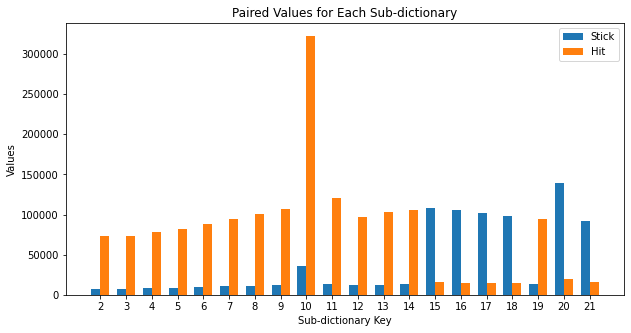

In [33]:
plot_Q_values(agent_v1.Q)
